
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Projet : Prédiction des débordements d'égoûts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/8b22a09b27944e458e86e7631c0ccfee

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre numéro d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul fichier .ipynb par équipe faisant office de rapport et permettant de reproduire vos meilleures prédictions doit être remis.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : on prédit 0 débordement à tous les jours. Ce sera votre travail d'améliorer ces prédictions naïves avec la méthode de votre choix.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode déjà implémentée et infructueuse.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.

In [48]:
using CSV, DataFrames, Gadfly, Statistics, Combinatorics, Dates, GLM, LinearAlgebra, Distributions
import StatsBase
import Random

In [49]:
function standardize!(X::Array{T,2} where T<:Real)

    m = mean(X, dims=1)
    s = std(X, dims=1)

    n, p = size(X)

    for i=1:n
        for j=1:p
            X[i,j] = (X[i,j] - m[j]) / s[j]
        end
    end

    return X

end

function standardize!(X::Array{T,1} where T<:Real)

    m = mean(X)
    s = std(X)

    n = length(X)

    for i=1:n
        X[i] = (X[i] - m) ./ s
    end

    return X

end

"""
    standardize(X)
Standardisation des colonnes de la matrice (ou vecteur) X.
### Arguments
- `X` : Matrice des données.
### Details
La fonction renvoie une copie de la matrice standardisée.
### Examples
\```
 julia> Z = standardize(X)
\```
"""
function standardize(X::Array{T,2} where T<:Real)

    m = mean(X, dims=1)
    s = std(X, dims=1)

    n, p = size(X)

    Z = zeros(n, p)

    for i=1:n
        for j=1:p
            Z[i,j] = (X[i,j] - m[j]) / s[j]
        end
    end

    return Z

end

function standardize(X::Array{T,1} where T<:Real)

    m = mean(X)
    s = std(X)

    n = length(X)

    Z = zeros(n)

    for i=1:n
        Z[i] = (X[i] - m) ./ s
    end

    return Z

end


standardize (generic function with 2 methods)

In [50]:
function compute_VIF(structureMatrix::Array{T,2} where T<:Real)

    n = size(structureMatrix,1)

    if all(isapprox.(structureMatrix[:,1], 1))
        m = size(structureMatrix,2)
        p = m-1  # nb de variables explicatives
        S = structureMatrix
    else
        p = size(structureMatrix,2)
        m = p+1
        S = hcat(ones(n), structureMatrix)
    end

    VIF = Float64[]

    for j in 2:m

        y = S[:,j]
        X = S[:, setdiff(1:m, j)]

        β̂ = X\y

        e = y - X*β̂

        SST = sum( (y .- mean(y)).^2)
        SSE = e'e

        R² = 1 - SSE/SST

        push!(VIF, 1/(1-R²))

    end

    return VIF

end


compute_VIF (generic function with 1 method)

In [51]:
function histnorm(train::DataFrame, edges::AbstractVector, varname::Symbol)

    center = (edges[1:end-1]+edges[2:end])/2

    c = Array{Float64}(undef,5,length(center))
    
    m = unique(train[:D_Mode_str])
    

    for i=1:length(m)
        ind = train[:D_Mode_str] .== m[i]
        x = train[ind, varname]

        h = fit(Histogram,x, edges)

        c[i,:] = h.weights

    end

    nᵢ = vec(sum(c, dims=1))

    df = DataFrame(Center = center)

    for i=1:5
        df[Symbol(m[i])] = c[i,:] ./ nᵢ
    end

    df = melt(df, :Center)

    rename!(df, :Center => varname)
    rename!(df, :value => :proportion)
    rename!(df, :variable => :D_Mode_str)

    return df
    
end


histnorm (generic function with 1 method)

In [52]:
function plotDistribution(mode::Int64, sym::Symbol, distribution)
    voi = data[data[:D_Mode] .== mode, :];
    if typeof(distribution) == MelangeNormales
        gmm = GMM(distribution.n, voi[sym]; method=:kmeans, nInit=100, nIter=20)
        fd = MixtureModel(gmm)
    else
        # fit_mle retourne les estimateurs avec le maximum de la vraisemblance (dans la plupart des cas)
        fd = fit_mle(distribution, voi[sym])
    end
    xx = 0:0.1:60;
    f = pdf.(fd, xx);
    h = layer(x = voi[sym], Geom.histogram(density = true));
    f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
    plot(f, h)
end


plotDistribution (generic function with 1 method)

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [53]:
data = CSV.read("train.csv", DataFrame)
first(data,5)

5×13 DataFrame
 Row │ Date        Duration  d15min   d30min   d45min   d1h      d2h      d3h  ⋯
     │ Date        Float64   Float64  Float64  Float64  Float64  Float64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2013-06-01       0.0     69.0    100.0    115.0    117.0    117.0    11 ⋯
   2 │ 2013-06-02       0.0     27.0     32.0     33.0     35.0     64.0     9
   3 │ 2013-06-04       0.0      0.0      0.0      0.0      0.0      0.0
   4 │ 2013-06-05       0.0      0.0      0.0      0.0      0.0      0.0
   5 │ 2013-06-06       0.0      5.0      7.0      9.0     12.0     19.0     2 ⋯
                                                               6 columns omitted

In [71]:
test = CSV.read("test.csv", DataFrame);
first(test,5)

5×12 DataFrame
 Row │ Date        d15min   d30min   d45min   d1h      d2h      d3h      d4h   ⋯
     │ Date        Float64  Float64  Float64  Float64  Float64  Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2013-06-03      0.0      0.0      0.0      0.0      0.0      0.0      0 ⋯
   2 │ 2013-06-07      5.0      9.0     12.0     16.0     26.0     31.0     36
   3 │ 2013-06-12      9.0     13.0     16.0     16.0     23.0     36.0     41
   4 │ 2013-06-13      2.0      2.0      2.0      2.0      2.0      2.0      2
   5 │ 2013-06-23      0.0      0.0      4.0      4.0      9.0     28.0     32 ⋯
                                                               5 columns omitted

## 2. Analyse exploratoire sommaire

C'est une analyse exploratoire sommaire. Je vous encourage formtement à poursuivre cette analyse.



#### 2.1 Surverse vs accumulation de pluie sur 2h

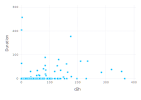

In [55]:
plot(data, x = :d2h, y = :Duration)

#### 2.2 Surverse vs accumulation de pluie sur 2h et 4h

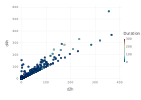

In [56]:
plot(data, x = :d2h, y = :d4h, color = :Duration)

#### 2.3 Surverse vs accumulation de pluie sur 2h et 4h

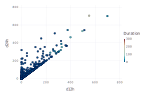

In [57]:
plot(data, x = :d12h, y = :d24h, color = :Duration)

D24H

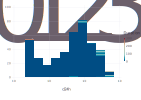

In [58]:
# TODO: Analyse exploratoire
plot(data, x=:d24h, color=:Duration, Geom.histogram(bincount=10), Scale.x_log10)

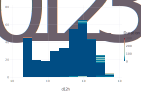

In [59]:
plot(data, x=:d12h, color=:Duration, Geom.histogram(bincount=10), Scale.x_log10)

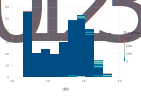

In [60]:
plot(data, x=:d6h, color=:Duration, Geom.histogram(bincount=10), Scale.x_log10)

#### 2.4 Variables crees

###### MOIS

On classifie chaque jour selon le mois dont il appartient. Nous pensons que le mois de l'année influence le montant de pluie qu'il y aura.

In [70]:
function addMonth(file::DataFrame)
    fileSize = size(file, 1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:, :Date])
        date = file[i, :Date];
        month = Dates.month(date)
        if month == 5
            d[i] = 0
        elseif month == 6
            d[i] = 1
        elseif month == 7
            d[i] = 2
        elseif month == 8
            d[i] = 3
        elseif month == 9
            d[i] = 4
        elseif month == 10
            d[i] = 5
        end
    end
    file[:, :Month] = d
end

addMonth(data)
addMonth(test)

740-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5

In [62]:
# TODO: Analyse exploratoire
plot(data, x=:Month, Geom.histogram(bincount=6))

LoadError: ArgumentError: column name :Month not found in the data frame

### DID_RAIN

In [67]:
function adddidRain(file::DataFrame)
    fileSize = size(file, 1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:, :d24h])
        accumulation = file[i, :d24h];
        print(accumulation)
        if accumulation > 0
            d[i] = 1
        else
            d[i] = 0
        end
    end
    file[:, :DID_RAIN] = d
end

adddidRain(test)
adddidRain(data)

123.0114.0346.038.0119.02.02.098.021.0113.0187.090.04.090.0237.03.0155.0392.0334.056.0289.013.02.010.042.0315.032.010.08.044.08.07.0173.021.0711.0163.073.054.025.07.0121.046.0241.02.0108.0500.02.0162.0116.0116.014.066.077.0163.013.02.087.05.0236.022.024.03.012.0210.04.011.034.014.026.02.04.0156.041.010.0128.04.050.073.055.083.0113.057.0110.053.0229.027.027.02.0105.023.029.02.0293.023.048.053.0549.053.02.02.061.0117.0240.00.00.045.0102.061.00.0312.02.00.0102.0102.00.00.00.00.0119.065.078.044.00.0174.0176.02.05.0183.00.00.06.072.062.00.03.03.00.0198.0388.0186.00.00.00.038.042.070.041.014.014.00.00.00.030.030.00.089.089.062.00.00.00.098.021.00.00.00.00.00.00.0113.00.00.092.092.083.05.0127.00.02.04.08.010.02.00.00.084.084.0183.02.02.00.090.00.00.02.02.02.0190.047.048.050.023.053.00.00.02.02.03.0155.00.09.012.064.00.00.07.0100.0100.02.00.00.00.00.00.00.06.083.094.00.00.00.07.092.085.00.00.00.040.04.00.00.00.00.00.00.00.00.00.010.00.00.00.00.042.00.0283.00.00.00.044.00.00.00.02.02.00.00.069.

740-element Array{Int64,1}:
 1
 1
 0
 0
 1
 1
 1
 0
 1
 1
 0
 1
 1
 ⋮
 0
 0
 1
 1
 1
 0
 0
 1
 1
 1
 0
 1

In [239]:
adddidRain(test)

123.0114.0346.038.0119.02.02.098.021.0113.0187.090.04.090.0237.03.0155.0392.0334.056.0289.013.02.010.042.0315.032.010.08.044.08.07.0173.021.0711.0163.073.054.025.07.0121.046.0241.02.0108.0500.02.0162.0116.0116.014.066.077.0163.013.02.087.05.0236.022.024.03.012.0210.04.011.034.014.026.02.04.0156.041.010.0128.04.050.073.055.083.0113.057.0110.053.0229.027.027.02.0105.023.029.02.0293.023.048.053.0549.053.02.02.061.0

101-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

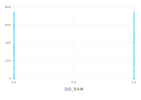

In [240]:
plot(data, x=:DID_RAIN)

### MAX_ACCUMULATION

In [241]:
function addMaxAccumulationDay(file::DataFrame)
    fileSize = size(file, 1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:d24h])
        max_accumulation = max(file[i, [:d15min, :d30min, :d45min, :d1h, :d2h, :d3h, :d4h, :d6h, :d8h, :d12h, :d24h]]...)
        d[i] = max_accumulation
    end
   
    file[:MAX_ACCUMULATION] = d
end

addMaxAccumulationDay(data)
addMaxAccumulationDay(test)

101-element Array{Int64,1}:
 123
 114
 346
  38
 119
   2
   2
  98
  21
 113
 187
  90
   4
   ⋮
  23
  29
   2
 293
  23
  48
  53
 549
  53
   2
   2
  61

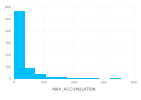

In [242]:
plot(data, x=:MAX_ACCUMULATION, Geom.histogram(bincount=10))

Suit possiblement un exponentielle?

In [243]:
struct MelangeNormales
    n::Int64
end
plotDistribution(1, :MAX_ACCUMULATION, Gamma)

LoadError: ArgumentError: column name :D_Mode not found in the data frame

## 3. Nettoyage des données

In [244]:
dropmissing(data)

740×16 DataFrame. Omitted printing of 10 columns
│ Row │ Date       │ Duration │ d15min  │ d30min  │ d45min  │ d1h     │
│     │ Date       │ Float64  │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2013-06-01 │ 0.0      │ 69.0    │ 100.0   │ 115.0   │ 117.0   │
│ 2   │ 2013-06-02 │ 0.0      │ 27.0    │ 32.0    │ 33.0    │ 35.0    │
│ 3   │ 2013-06-04 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 4   │ 2013-06-05 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 5   │ 2013-06-06 │ 0.0      │ 5.0     │ 7.0     │ 9.0     │ 12.0    │
│ 6   │ 2013-06-08 │ 0.0      │ 14.0    │ 20.0    │ 24.0    │ 29.0    │
│ 7   │ 2013-06-09 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 8   │ 2013-06-10 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 9   │ 2013-06-11 │ 13.0     │ 18.0    │ 32.0    │ 43.0    │ 54.0    │
│ 10  │ 2013-06-14 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
⋮
│ 730 │ 2019-10-21 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 731 │ 2019-10-22 │ 0.0      │ 14.0    │ 28.0    │ 39.0    │ 53.0    │
│ 732 │ 2019-10-23 │ 0.0      │ 12.0    │ 25.0    │ 36.0    │ 50.0    │
│ 733 │ 2019-10-24 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 734 │ 2019-10-25 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 735 │ 2019-10-26 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 736 │ 2019-10-27 │ 61.7167  │ 33.0    │ 63.0    │ 88.0    │ 102.0   │
│ 737 │ 2019-10-28 │ 0.0      │ 2.0     │ 2.0     │ 2.0     │ 2.0     │
│ 738 │ 2019-10-29 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 739 │ 2019-10-30 │ 0.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 740 │ 2019-10-31 │ 73.3333  │ 47.0    │ 89.0    │ 122.0   │ 146.0   │

## 4. Préparation

#### 4.1 Verification de multicolinearite

In [245]:
variables = names(data[3:16])

14-element Array{String,1}:
 "d15min"
 "d30min"
 "d45min"
 "d1h"
 "d2h"
 "d3h"
 "d4h"
 "d6h"
 "d8h"
 "d12h"
 "d24h"
 "Month"
 "DID_RAIN"
 "MAX_ACCUMULATION"

In [246]:
df = DataFrame(Variable = String[], VIF = Float64[])

for variable in combinations(variables,1)
    y = data[:, variable[] ]
    ȳ = mean(y)
    X = hcat(ones(n), convert(Matrix{Float64}, data[:, setdiff(variables, variable)]) )
    β̂ = X\y
    ŷ = X*β̂
    e = y-ŷ
    SSE = e'*e
    SST = sum( (y .- ȳ).^2 )
    R² = 1 - SSE/SST
    VIF = 1/(1-R²)
    push!(df, [variable[], VIF])
end

df


14×2 DataFrame
│ Row │ Variable         │ VIF     │
│     │ String           │ Float64 │
├─────┼──────────────────┼─────────┤
│ 1   │ d15min           │ 38.1586 │
│ 2   │ d30min           │ 138.878 │
│ 3   │ d45min           │ 259.765 │
│ 4   │ d1h              │ 170.996 │
│ 5   │ d2h              │ 104.926 │
│ 6   │ d3h              │ 128.787 │
│ 7   │ d4h              │ 135.331 │
│ 8   │ d6h              │ 62.2068 │
│ 9   │ d8h              │ 30.4133 │
│ 10  │ d12h             │ 25.9266 │
│ 11  │ d24h             │ Inf     │
│ 12  │ Month            │ 1.01787 │
│ 13  │ DID_RAIN         │ 1.34795 │
│ 14  │ MAX_ACCUMULATION │ Inf     │

### Selection des variables explicatives par comparaison de R2 

In [247]:
y = data[:, :Duration]
ȳ = mean(y)
SST = sum( (y .- ȳ).^2 )


df = DataFrame(Variable = Vector{String}[], R² = Float64[])

for variable in combinations(variables)
    
    p = length(variable)
    
    X = hcat(ones(n), convert(Matrix{Float64},data[:, variable]))
    
    
    β̂ = X\y
    ŷ = X*β̂

    e = y-ŷ

    SSE = e'*e

    R²aj =  1 - SSE/SST * (n-1)/(n-p)
    
    push!(df, [variable, R²aj])
#     println(variable)
    
end

sort(df, :R², rev=true)


16383×2 DataFrame
│ Row   │ Variable                                           │ R²        │
│       │ Array{String,1}                                    │ Float64   │
├───────┼────────────────────────────────────────────────────┼───────────┤
│ 1     │ ["d1h", "d2h", "d6h", "Month"]                     │ 0.119577  │
│ 2     │ ["d1h", "d2h", "d6h", "d12h", "Month"]             │ 0.118729  │
│ 3     │ ["d1h", "d2h", "d6h", "d8h", "Month"]              │ 0.118673  │
│ 4     │ ["d1h", "d2h", "d8h", "Month"]                     │ 0.118655  │
│ 5     │ ["d1h", "d2h", "d6h", "d24h", "Month"]             │ 0.118627  │
│ 6     │ ["d1h", "d2h", "d6h", "Month", "MAX_ACCUMULATION"] │ 0.118627  │
│ 7     │ ["d45min", "d1h", "d2h", "d6h", "Month"]           │ 0.118607  │
│ 8     │ ["d15min", "d1h", "d2h", "d6h", "Month"]           │ 0.118584  │
│ 9     │ ["d1h", "d2h", "d6h", "Month", "DID_RAIN"]         │ 0.118441  │
│ 10    │ ["d1h", "d2h", "d3h", "d6h", "Month"]              │ 0.118437  │
⋮
│ 16373 │ ["d15min", "d30min", "DID_RAIN"]                   │ 0.0477124 │
│ 16374 │ ["d15min", "Month", "DID_RAIN"]                    │ 0.047033  │
│ 16375 │ ["d15min", "d30min"]                               │ 0.0469707 │
│ 16376 │ ["d15min", "Month"]                                │ 0.0453938 │
│ 16377 │ ["d30min", "DID_RAIN"]                             │ 0.042368  │
│ 16378 │ ["d30min"]                                         │ 0.0416039 │
│ 16379 │ ["d15min", "DID_RAIN"]                             │ 0.0361231 │
│ 16380 │ ["d15min"]                                         │ 0.0346007 │
│ 16381 │ ["Month", "DID_RAIN"]                              │ 0.0240651 │
│ 16382 │ ["DID_RAIN"]                                       │ 0.0128627 │
│ 16383 │ ["Month"]                                          │ 0.0123843 │

### Regression ridge

In [248]:
ty = StatsBase.fit(StatsBase.ZScoreTransform, data.Duration, dims=1)
y = StatsBase.transform(ty, data.Duration)
tx = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(data[:,3:end]), dims=1)
X = StatsBase.transform(tx, Matrix{Float64}(data[:,3:end]));

In [249]:
n = length(y)
m = size(X,2)

λ = .2

β̂ᵣ = (X'X + λ*I)\X'y

s² = (y'y - β̂ᵣ'*(X'X + λ*I)*β̂ᵣ)/n

Σ = Symmetric(inv(X'X+λ*I))


println("β̂ᵣ = ", β̂ᵣ)
println("s² = ", s²)

β̂ᵣ = [0.15515167491349163, -0.31835422325425616, 0.35342687664721084, -0.7815522660280955, 0.6688277329553881, -0.032504822832882405, -0.002317270998231093, 0.20033495389798803, 0.01239813211605997, 0.03199145740554731, 0.005421188232624891, 0.0824832209392587, -0.014590786864026702, 0.0054211882328145805]
s² = 0.8743174219964414


#### Echantilonnage de Gibbs pour trouver la selection de variables explicatives

In [250]:
f₁(σ²::Real) = MvNormal(β̂ᵣ,σ²*Σ)
f₂(β::Vector{<:Real}) = InverseGamma((n+m)/2, .5(y-X*β)'*(y-X*β) + .5*λ*β'β)

f₂ (generic function with 1 method)

In [251]:
niter = 1000

β = Array{Float64}(undef, m, niter)
σ² = Array{Float64}(undef, niter)

β[:,1] = zeros(m)
σ²[1] = .05

for j in 2:niter
    β[:,j] = rand(f₁(σ²[j-1]))
    σ²[j] = rand(f₂(β[:,j]))
end

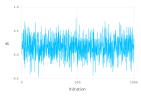

In [252]:
fig = plot(y=β[1,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₁"))

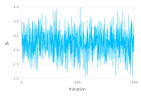

In [253]:
fig = plot(y=β[4,:], Geom.line, Guide.xlabel("Itération"), Guide.ylabel("β₄"))

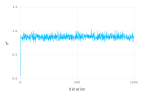

In [254]:
fig = plot(y=σ², Geom.line, Guide.xlabel("Itération"), Guide.ylabel("σ²"))

In [255]:
β = β[:, 101:1000]
σ² = σ²[101:1000];

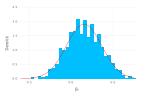

In [256]:
f = LocationScale(β̂ᵣ[1], sqrt(s²*Σ[1,1]), TDist(n))

fig = plot(Guide.xlabel("β₁"), Guide.ylabel("Densité"), Coord.cartesian(xmin=-.6, xmax=.75),
    layer(x->pdf(f, x), -.6, .75, Theme(default_color=colorant"red")),
    layer(x=β[1,:], Geom.histogram(density=true, bincount=30))
)

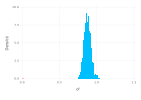

In [257]:
f = InverseGamma(n/2,n*s²/2)

fig = plot(Guide.xlabel("σ²"), Guide.ylabel("Densité"),
    layer(x->pdf(f, x), 0, .02, Theme(default_color=colorant"red")),
    layer(x=σ², Geom.histogram(density=true, bincount=30))
)

In [276]:
X_valid = StatsBase.transform(tx, Matrix{Float64}(test[:,2:15]));

ŷ = StatsBase.reconstruct(ty, X_valid*β̂ᵣ)

101-element Array{Float64,1}:
 -1.0530887987665158
  3.92650419512918
  4.6196581027817825
 -1.0571123989271292
  2.738577442415709
 -2.0278369092071777
 -2.046655290946007
  0.2866797022146399
  0.5611460122864682
 -0.20123309468878858
 14.87005271078424
 -1.5342504455529267
 -1.8027275452367886
  ⋮
  0.608694052409684
  0.3200674212251171
  0.40900563105254606
  4.507224986461972
  3.6858286396640842
  2.8646274065281077
  2.494962308924232
 29.031777213560794
  8.83221378002981
  1.8156535317304776
  1.95392916012314
  7.951949871157642

In [277]:
test[:, :Duration] = ŷ

101-element Array{Float64,1}:
 -1.0530887987665158
  3.92650419512918
  4.6196581027817825
 -1.0571123989271292
  2.738577442415709
 -2.0278369092071777
 -2.046655290946007
  0.2866797022146399
  0.5611460122864682
 -0.20123309468878858
 14.87005271078424
 -1.5342504455529267
 -1.8027275452367886
  ⋮
  0.608694052409684
  0.3200674212251171
  0.40900563105254606
  4.507224986461972
  3.6858286396640842
  2.8646274065281077
  2.494962308924232
 29.031777213560794
  8.83221378002981
  1.8156535317304776
  1.95392916012314
  7.951949871157642

In [279]:
for i=1:length(test[:,:Duration])
    duration = test[i, :Duration]
    if duration < 5 && duration > -5
        test[i, :Duration] = 0
    end
end
prediction = select(test, :Date, :Duration)
CSV.write("benchmark_predictions.csv",prediction)

"benchmark_predictions.csv"

### Analyse en composantes principales

Dans le but d'eliminer la multicolinearite, nous effectuons une PCA

X = convert(Array{Float64}, data[:, 3:end])

y = data.Duration

Z = standardize(X)
standardize!(y)

Z

F = svd(Z)
U = F.U
V = F.V
γ = F.S
w = round.(V[:,1], digits=2)

println("La première composante principale est composée de : ")
println("\t  T₁ = $(w[1]) Z₁ + $(w[2]) Z₂ + $(w[3]) Z₃ + $(w[4]) Z₄ + $(w[5]) Z₅")

v = cumsum(γ.^2) / sum(γ.^2)

Il faut utiliser 4 composantes principales afin d'expliquer 96% de la variance.

T = Z*V
η̂ = T\y
β̂ = V*η̂

X_test = convert(Array{Float64}, test[:, 2:15])
Z_test = standardize(X_test)
F = svd(Z)
U = F.U
V = F.V
γ = F.S
w = round.(V[:,1], digits=2)
v = cumsum(γ.^2) / sum(γ.^2)
T = Z*V
η̂ = T\y
β̂ = V*η̂
ŷ = Z_test*β̂

## Approche

1. Faire une classification pour determiner quelle date a eu une duree positive de deversement. Le resultat de la classification sera soit 0, s'il n'y a aucun deversement, ou 1 s'il y a eu lieu.

    1.1 Pour les dates ou il y a eu un deversement, faire une regression lineaire pour predire (pas tres accurate)
    
    1.2 Pour les dates ou aucun deversement, mettre la duree a 0.

#### 5.1 Regression logistique

In [260]:
# TODO

#### 5.2 Regression lineaire

Avec les variables ["d1h", "d2h", "d6h", "Month"] ayant le R^2 le plus eleve

In [261]:
x_15 = data[:, :d15min]
x_30 = data[:, :d30min]
x_45 = data[:, :d45min]
x_1h = data[:, :d1h]
x_2h = data[:, :d2h]
x_3h = data[:, :d3h]
x_4h = data[:, :d4h]
x_6h = data[:, :d6h]
x_8h = data[:, :d8h]
x_12h = data[:, :d12h]
x_24h = data[:, :d24h]
x_month = data[:, :Month]
y = data[:, :Duration]
n = length(y)

740

In [262]:
X = hcat(ones(n), x_1h, x_2h, x_6h, x_month)
β̂ = X \ y
println("Les estimations des coefficient de régression sont β̂ = ", β̂)

Les estimations des coefficient de régression sont β̂ = [-1.7404104252273858, -0.26590869321144756, 0.2409116838708066, 0.0604008474122834, 0.7855525301248649]


In [263]:
x = DataFrame()
x.d1h = test[:, :d1h]
x.d2h = test[:, :d2h]
x.d6h = test[:, :d6h]
x.Month = test[:, :Month]
X = convert(Array{Float64}, x)
#X = transpose(X)

101×4 Array{Float64,2}:
   0.0    0.0    0.0  1.0
  16.0   26.0   49.0  1.0
  16.0   23.0   52.0  1.0
   2.0    2.0    2.0  1.0
   4.0    9.0   32.0  1.0
   0.0    0.0    0.0  0.0
   0.0    0.0    0.0  0.0
   0.0    0.0    0.0  2.0
   0.0    3.0    3.0  2.0
   0.0    0.0    0.0  2.0
  61.0   96.0  170.0  0.0
   0.0    0.0    0.0  0.0
   2.0    2.0    4.0  0.0
   ⋮                  
   0.0    0.0    2.0  3.0
   0.0    0.0    0.0  3.0
   2.0    2.0    2.0  3.0
  19.0   22.0   37.0  4.0
  13.0   19.0   23.0  4.0
  20.0   23.0   25.0  4.0
   5.0    5.0   25.0  4.0
 285.0  332.0  504.0  5.0
  15.0   33.0   51.0  5.0
   0.0    0.0    0.0  5.0
   2.0    2.0    2.0  5.0
  20.0   33.0   61.0  5.0

In [264]:
beta = β̂[2:end]

4-element Array{Float64,1}:
 -0.26590869321144756
  0.2409116838708066
  0.0604008474122834
  0.7855525301248649

In [265]:
test[:, :Duration] .= X*beta

for i=1:length(test[:,:Duration])
    duration = test[i, :Duration]
    if duration < 5
        test[i, :Duration] = 0
    end
end

In [266]:
prediction = select(test, :Date, :Duration)

101×2 DataFrame
│ Row │ Date       │ Duration │
│     │ Date       │ Float64  │
├─────┼────────────┼──────────┤
│ 1   │ 2013-06-03 │ 0.0      │
│ 2   │ 2013-06-07 │ 5.75436  │
│ 3   │ 2013-06-12 │ 5.21283  │
│ 4   │ 2013-06-13 │ 0.0      │
│ 5   │ 2013-06-23 │ 0.0      │
│ 6   │ 2014-05-23 │ 0.0      │
│ 7   │ 2014-05-29 │ 0.0      │
│ 8   │ 2014-07-14 │ 0.0      │
│ 9   │ 2014-07-16 │ 0.0      │
│ 10  │ 2014-07-24 │ 0.0      │
⋮
│ 91  │ 2019-08-22 │ 0.0      │
│ 92  │ 2019-08-26 │ 0.0      │
│ 93  │ 2019-09-03 │ 5.62483  │
│ 94  │ 2019-09-10 │ 5.65194  │
│ 95  │ 2019-09-23 │ 0.0      │
│ 96  │ 2019-09-24 │ 0.0      │
│ 97  │ 2019-10-01 │ 38.5685  │
│ 98  │ 2019-10-04 │ 10.9697  │
│ 99  │ 2019-10-06 │ 0.0      │
│ 100 │ 2019-10-15 │ 0.0      │
│ 101 │ 2019-10-16 │ 10.2441  │

In [267]:
CSV.write("benchmark_predictions.csv",prediction)

"benchmark_predictions.csv"